In [10]:
import torch

from perceiver.model.core import (
    PerceiverDecoder,
    PerceiverEncoder,
    PerceiverIO
)

from perceiver.model.core.classifier import ClassificationOutputAdapter
from perceiver.model.core.adapter import TrainableQueryProvider

from perceiver.model.vision.image_classifier import ImageInputAdapter

from torch import nn, optim

from dataloader import xrd_dataloader
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from perceiver.model.core import (
    PerceiverDecoder,
    PerceiverEncoder,
    PerceiverIO
)

from perceiver.model.core.classifier import ClassificationOutputAdapter
from perceiver.model.core.adapter import TrainableQueryProvider

from perceiver.model.vision.image_classifier import ImageInputAdapter


# Fourier-encodes pixel positions and flatten along spatial dimensions
input_adapter = ImageInputAdapter(
  image_shape=(10000, 1),  # M = 224 * 224
  num_frequency_bands=64,
)

# Projects generic Perceiver decoder output to specified number of classes
output_adapter = ClassificationOutputAdapter(
  num_classes=10000,
  num_output_query_channels=512,  # F
)

# Generic Perceiver encoder
encoder = PerceiverEncoder(
  input_adapter=input_adapter,
  num_latents=512,  # N
  num_latent_channels=512,  # D changed from 1028
  num_cross_attention_qk_channels=input_adapter.num_input_channels,  # C
  num_cross_attention_heads=1,
  num_self_attention_heads=8,
  num_self_attention_layers_per_block=6,
  num_self_attention_blocks=8,
  dropout=0.0,
)

query_provider = TrainableQueryProvider(1, 512) # very arbitrary!

# Generic Perceiver decoder
decoder = PerceiverDecoder(
  output_adapter=output_adapter,
  output_query_provider=query_provider,
  num_latent_channels=512,  # D
  num_cross_attention_heads=1,
  dropout=0.0,
)

# Perceiver IO image classifier
mse_loss = nn.MSELoss()
model = PerceiverIO(encoder, decoder)

print('number of parameters: ', sum(p.numel() for p in model.parameters()))


number of parameters:  17135010


In [12]:
batch

NameError: name 'batch' is not defined

In [54]:

for item in xrd_dataloader:
    print(item.size())
    batch1 = item
    batch = item.reshape(2, 10000, 1)
    break

torch.Size([2, 1, 10000])


In [48]:
batch[0, :, 0].detach().numpy()

tensor([0.2013, 0.3825, 0.3120,  ..., 0.1711, 0.5033, 0.2617],
       dtype=torch.float64)

In [35]:
item.detach().numpy()[0,0, :].shape

(10000,)

In [42]:
out_spectra = out.detach().numpy()[0, :]

In [38]:
out = model(batch.bfloat16())

In [28]:
out.detach().numpy()[0, :].shape
spectra = out.detach().numpy()[0, :]

In [27]:
import matplotlib.pyplot as plt

In [36]:
spectra2 = item.detach().numpy()[0,0, :]

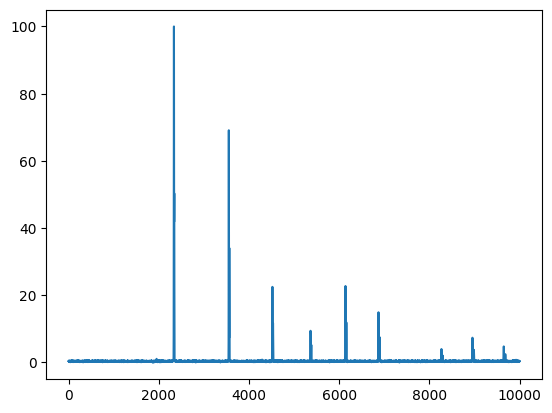

In [55]:
plt.plot(batch[0, :, 0].detach().numpy())

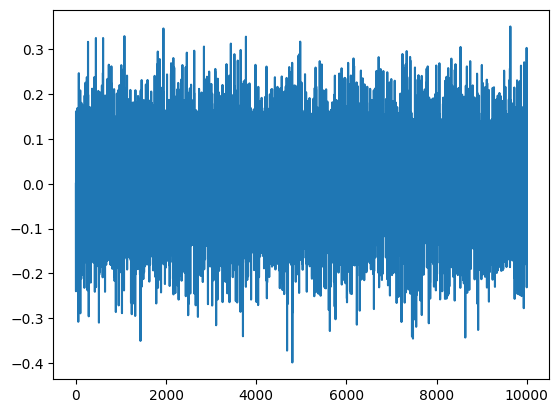

In [43]:
plt.plot(out_spectra)

In [6]:
def train_model(num_epochs=100):
    outputs = []
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(num_epochs):
        for idx, data in enumerate(xrd_dataloader):
            data = data.reshape(2, 10000, 1)
            data = data.float()
            # data = data.to(device)
            # ===================forward=====================
            output = model(data)
            loss = mse_loss(output, data.squeeze())
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 5 == 0:
                print(f"Finished batch {idx} in epoch {epoch + 1}. Loss: {loss.item():.4f}")

        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        outputs.append((epoch, data, output))



# Train the model

model.train(True)
train_model(num_epochs=1)
model.train(False)

Finished batch 0 in epoch 1. Loss: 18.4822
Finished batch 5 in epoch 1. Loss: 9.4643
Finished batch 10 in epoch 1. Loss: 11.5769
Finished batch 15 in epoch 1. Loss: 11.0763
Finished batch 20 in epoch 1. Loss: 22.1717
Finished batch 25 in epoch 1. Loss: 11.4644


KeyboardInterrupt: 

In [7]:
data

NameError: name 'data' is not defined